In [1]:
import os
import numpy as np
from sklearn.decomposition import PCA
import random
import matplotlib.pyplot as plt
import sys
sys.path.insert(1, '../src/')
from config import raw_data_path, univariate_data_path, processed_data_path

In [4]:
dataset = 'tpehgdb'

In [11]:
import os
import numpy as np
from sklearn.decomposition import PCA

def univariate(dataset_name):
    data_dir = os.path.join(processed_data_path, dataset_name + "_preprocessed.npy")
    data = np.load(data_dir, allow_pickle=True)

    # Define the path to save the new dataset
    save_dir = os.path.join(univariate_data_path, dataset_name + "_univariate.npy")

    # Initialize a list for storing modified entries
    univariate_data = []
    retained_variances = []  # List to store retained variance for each entry

    for entry in data:
        # Copy the entry to preserve metadata
        new_entry = entry.copy()

        # Extract the signal matrix (shape: (599999, 6))
        signal_matrix = entry['signal']
        
        # Apply PCA to reduce from 6D to 1D
        pca = PCA(n_components=1)
        reduced_signal = pca.fit_transform(signal_matrix)  # Shape: (599999, 1)
        
        # Calculate retained variance
        retained_variance = np.sum(pca.explained_variance_ratio_)
        retained_variances.append(retained_variance)

        print(f"Retained Variance for {entry['record_name']}: {retained_variance:.6f}")
        
        # Flatten to (599999,) to retain time-series format
        new_entry['signal'] = reduced_signal.flatten()

        # Append modified entry to the new dataset
        univariate_data.append(new_entry)

    # Compute the average retained variance for the dataset
    avg_retained_variance = np.mean(retained_variances)
    print(f"\nAverage Retained Variance for {dataset_name}: {avg_retained_variance:.6f}")

    # Convert to a NumPy array and save
    np.save(save_dir, np.array(univariate_data, dtype=object))

    print(f"PCA transformation complete. Saved as '{save_dir}'.")

univariate('nifeadb')


Retained Variance for ARR_01: 0.838394
Retained Variance for ARR_02: 0.531885
Retained Variance for ARR_03: 0.463051
Retained Variance for ARR_04: 0.531407
Retained Variance for ARR_05: 0.802113
Retained Variance for ARR_06: 0.680092
Retained Variance for ARR_07: 0.801713
Retained Variance for ARR_08: 0.842037
Retained Variance for ARR_09: 0.832517
Retained Variance for ARR_10: 0.626628
Retained Variance for ARR_11: 0.826809
Retained Variance for ARR_12: 0.864628
Retained Variance for NR_01: 0.821890
Retained Variance for NR_02: 0.679275
Retained Variance for NR_03: 0.509599
Retained Variance for NR_04: 0.617685
Retained Variance for NR_05: 0.670962
Retained Variance for NR_06: 0.667240
Retained Variance for NR_07: 0.818575
Retained Variance for NR_08: 0.679510
Retained Variance for NR_09: 0.637419
Retained Variance for NR_10: 0.480174
Retained Variance for NR_11: 0.411022
Retained Variance for NR_12: 0.415964
Retained Variance for NR_13: 0.531885
Retained Variance for NR_14: 0.818575


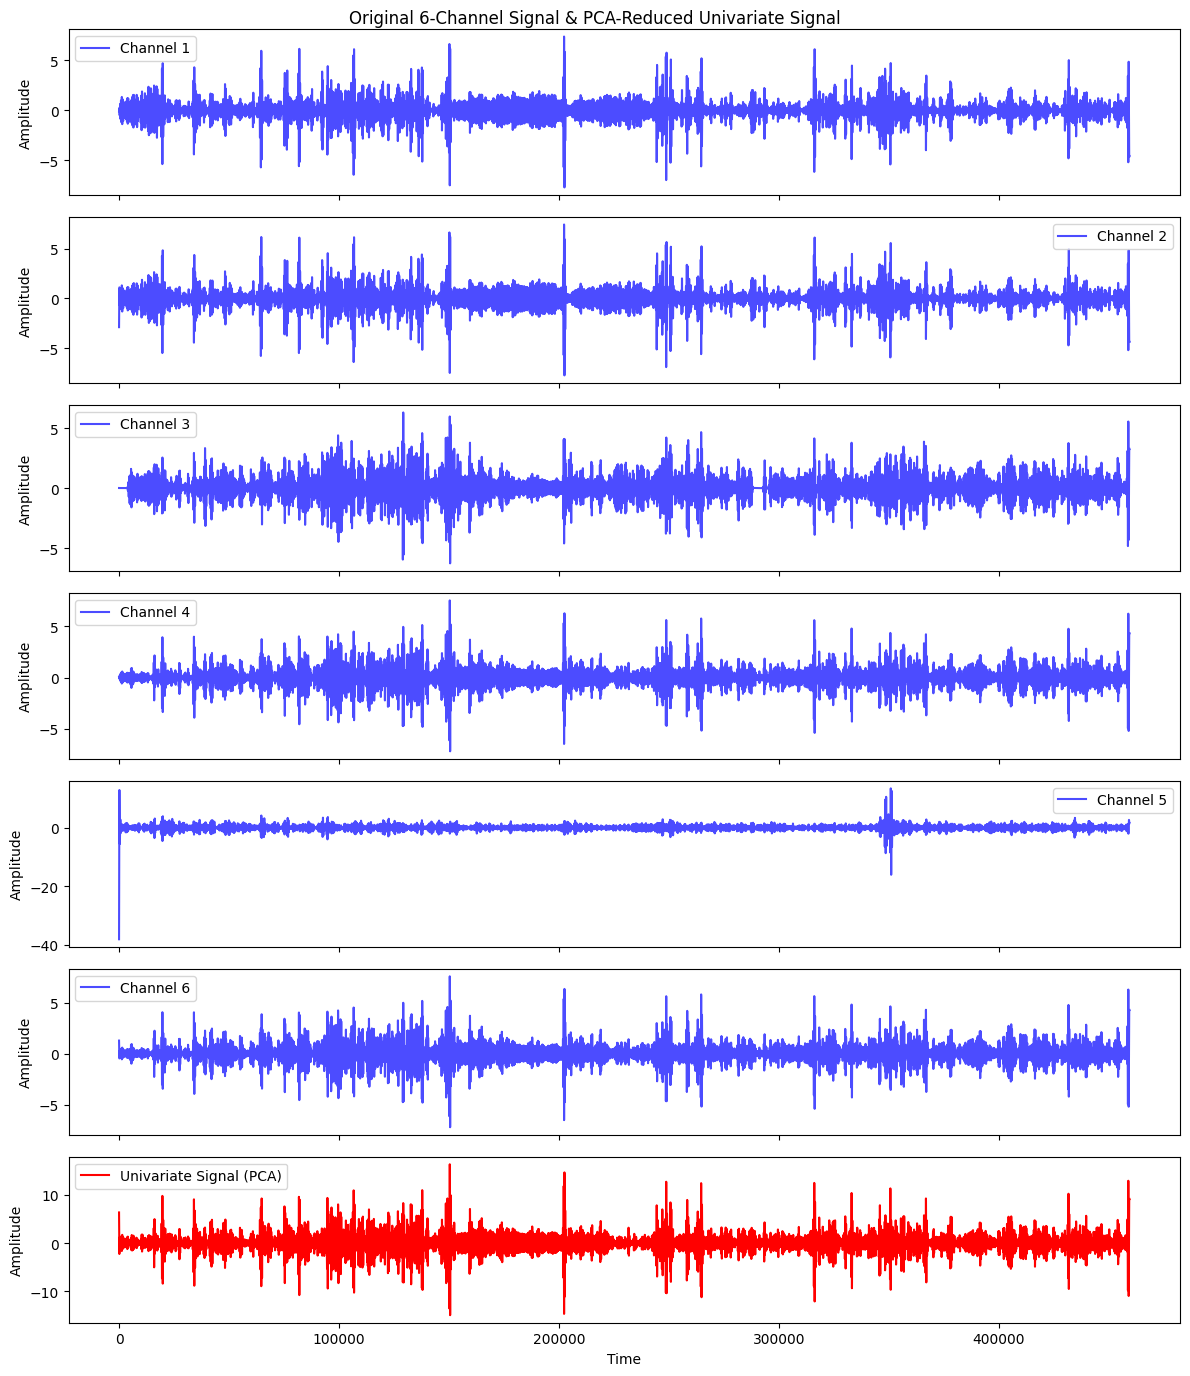

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import os
import random

# Load dataset
data_path = os.path.join(univariate_data_path, dataset + "_univariate.npy")
data = np.load(data_path, allow_pickle=True)

# Select a random instance for visualization
random_instance = random.choice(data)
univariate_signal = random_instance['signal']  # Univariate after PCA

# Load the original dataset before PCA
original_data_path = os.path.join(processed_data_path, dataset + "_preprocessed.npy")
original_data = np.load(original_data_path, allow_pickle=True)

# Find the corresponding original signal
record_name = random_instance['record_name']
original_instance = next(entry for entry in original_data if entry['record_name'] == record_name)
original_multivariate_signal = original_instance['signal']  # Shape: (sequence_length, num_channels)

num_channels = original_multivariate_signal.shape[1]  

# Create subplots (num_channels + 1 to include the univariate signal)
fig, axs = plt.subplots(num_channels + 1, 1, figsize=(12, 2 * (num_channels + 1)), sharex=True)

time_axis = np.arange(original_multivariate_signal.shape[0])

# Plot all channels dynamically
for i in range(num_channels):
    axs[i].plot(time_axis, original_multivariate_signal[:, i], label=f'Channel {i+1}', color='b', alpha=0.7)
    axs[i].legend()
    axs[i].set_ylabel("Amplitude")

# Plot the univariate signal in a distinct color
axs[num_channels].plot(time_axis, univariate_signal, label="Univariate Signal (PCA)", color='r')
axs[num_channels].legend()
axs[num_channels].set_ylabel("Amplitude")
axs[num_channels].set_xlabel("Time")

fig.suptitle(f"Original {num_channels}-Channel Signal & PCA-Reduced Univariate Signal")
plt.tight_layout()
plt.show()
